<h1>Natural Language Processing with Disaster Tweets</h1>

<b>Predict which Tweets are about real disasters and which ones are not</b>

<h2>Getting Started</h2>

This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. The competition dataset is not too big, and even if you don’t have much personal computing power, you can do all of the work in our free, no-setup, Jupyter Notebooks environment called Kaggle Notebooks.

Link: https://www.kaggle.com/c/nlp-getting-started

<h2>Dataset</h2>

The project contains 3 datasets.
1. train.csv - the training set
2. test.csv - the test set
3. sample_submission.csv - a sample submission file in the correct format

<h3>train.csv</h3>

Each sample in the train and test set has the following information:

1. The <b>text</b> of a tweet
2. A <b>keyword</b> from that tweet (although this may be blank!)
3. The <b>location</b> the tweet was sent from (may also be blank)

We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

<h4>Columns</h4>

1. id - a unique identifier for each tweet
2. text - the text of the tweet
3. location - the location the tweet was sent from (may be blank)
4. keyword - a particular keyword from the tweet (may be blank)
5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

<h2>Evaluation</h2>

Submissions are evaluated using <b>F1</b> between the predicted and expected answers.


<h1>1. Import Dataset and Libraries</h1>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
import pickle
import operator
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as pt
import sklearn

from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

import tensorflow as tf
import tensorflow_hub
import transformers
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Embedding, LSTM, Activation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%%time
train_df = pd.read_csv("/content/drive/MyDrive/Data/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Data/test.csv")

CPU times: user 27.4 ms, sys: 9.95 ms, total: 37.4 ms
Wall time: 2.19 s


In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print("Shape of the train dataset is:",train_df.shape)
print("Shape of the test dataset is:",test_df.shape)

Shape of the train dataset is: (7613, 5)
Shape of the test dataset is: (3263, 4)


<h2>1.1 checking for missing values</h2>

In [ ]:
missing_status = train_df.isna().any().any()
print("Are there any missing values present in the dataset?")
print('No' if missing_status==False else "Yes")

Are there any missing values present in the dataset?
Yes


In [ ]:
train_df.apply(lambda x: sum(x.isnull()),axis=0)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<pre>Keywards and location data has some amount of missing values here. As we are not dealing with these features, we don't need to fill the NA values.</pre>

<h2>1.2 checking for duplicate rows</h2>

In [ ]:
duplicate_status = len(train_df[train_df["text"].duplicated()])
print("Are there any duplicate rows present in the dataset?")
print('No' if duplicate_status==0 else "Yes")

Are there any duplicate rows present in the dataset?
Yes


In [ ]:
#using groupby to get counts
temp_df = train_df.groupby(['text']).size().reset_index(name='counts')
#number of duplicate rows
print("There are {} sentences in the dataset which has occured more than once."
      .format(len(temp_df[temp_df["counts"] > 1])))
#duplicate rows
print("They are:\n",temp_df[temp_df["counts"] > 1])

There are 69 sentences in the dataset which has occured more than once.
They are:
                                                    text  counts
24    #Allah describes piling up #wealth thinking it...       3
45    #Bestnaijamade: 16yr old PKK suicide bomber wh...       6
115   #KCA #VoteJKT48ID 12News: UPDATE: A family of ...       2
141   #Myanmar  Displaced #Rohingya at #Sittwe point...       2
157   #Newswatch: 2 vehicles collided at Lock and La...       2
...                                                 ...     ...
7237  incident with injury:I-495  inner loop Exit 31...       2
7265  like for the music video I want some real acti...       2
7371  that exploded &amp; brought about the\nbeginni...       2
7372  that horrible sinking feeling when youÛªve be...       4
7449  wowo--=== 12000 Nigerian refugees repatriated ...       2

[69 rows x 2 columns]


In [ ]:
print("Before dropping duplicates total rows present : {}".format(train_df["text"].shape[0]))
#dropping duplicates
df = train_df.drop_duplicates(subset ="text") 
print("After dropping duplicates total rows present : {}".format(df["text"].shape[0]))

Before dropping duplicates total rows present : 7613
After dropping duplicates total rows present : 7503


<h2>1.3 info of features</h2>

In [ ]:
#getting features type information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


<h2>1.4 target value analysis</h2>

Positive Tweets :  3198
Negative Tweets :  4305


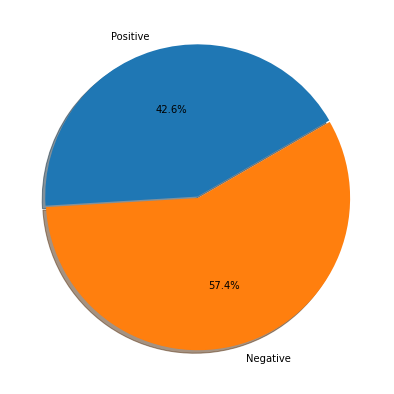

In [ ]:
#number of questions in the train dataset in both the class
targets = df['target'].value_counts()
print('Positive Tweets : ',targets[1])
print('Negative Tweets : ',targets[0])

labels = 'Positive', 'Negative'
values = [targets[1], targets[0]]
explode = (0, 0.01)
fig = pt.figure(figsize=(15,7))
pt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=30)
pt.show()

<pre>
Target value seems like a partially imbalance dataset where 43% belongs to positive class and rest negative.</pre>

<h2>1.5 tweet analysis</h2>

In [ ]:
#positive tweets
print("Positive Tweets: ")
print(df[df['target'] == 1]["text"].values[0])
print(df[df['target'] == 1]["text"].values[3])
#negative tweets
print("\nNegative Tweets: ")
print(df[df['target'] == 0]["text"].values[0])
print(df[df['target'] == 0]["text"].values[3])

Positive Tweets: 
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
13,000 people receive #wildfires evacuation orders in California 

Negative Tweets: 
What's up man?
My car is so fast


<h1>2. Exploratory Data Analysis</h1>
<h2>2.1 Univariate Analysis</h2>
<h3>2.1.1 keyword</h3>

In [ ]:
#keyword is text object. It's has all words only.
df["keyword"] = df["keyword"].str.lower()
keywords = dict(df["keyword"].value_counts())

print("Total unique words present in keyword: {}".format(len(keywords)))
print("Top 10 frequent words: \n{}".format(list(keywords.keys())[0:20]))

Total unique words present in keyword: 221
Top 10 frequent words: 
['fatalities', 'armageddon', 'deluge', 'harm', 'damage', 'body%20bags', 'evacuate', 'siren', 'fear', 'windstorm', 'twister', 'collided', 'sunk', 'famine', 'outbreak', 'collision', 'explosion', 'flames', 'weapon', 'earthquake']


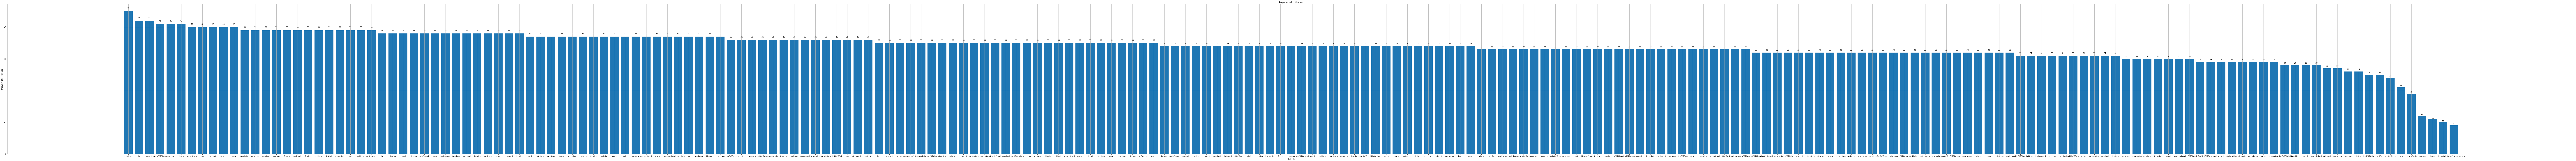

In [ ]:
#distribution plot
fig = pt.figure(figsize = (250,15))
ax = pt.gca()
ax.bar(list(keywords.keys()), list(keywords.values()))
ax.set(xlabel="keywords", ylabel="frequncy of occurance", title="keywords distribution")
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')
ax.grid()
pt.show()

<i><b>keyword feature may helpful as it covers symantic words related to disaster. But we are not covering this as there many missing values present.</b></i>

<h3>2.1.2 Location</h3>

In [ ]:
#keyword is text object. It's has all words only.
df["location"] = df["location"].str.lower()
locations = dict(df["location"].value_counts())

print("Total unique words present in location: {}".format(len(locations)))
print("Top 10 frequent words: \n{}".format(list(locations.keys())[0:20]))

Total unique words present in location: 3220
Top 10 frequent words: 
['usa', 'new york', 'united states', 'london', 'canada', 'worldwide', 'uk', 'los angeles, ca', 'nigeria', 'india', 'mumbai', 'kenya', 'washington, dc', 'everywhere', 'chicago, il', 'california', 'australia', 'new york, ny', 'nyc', 'california, usa']


<i><b>No matter what is your location if a tweet is fake/not true means doesn't add any value. So location won't be included.</b></i>

<h3>2.1.3 Text/Tweets</h3>

<h4>character length distributions of the tweets</h4>

In [ ]:
df["length_of_tweets"] = df["text"].str.len()
print("Minimum and Maximum length of characters in a tweet present in the dataset is {} and {} respectively.".
      format(min(df["length_of_tweets"]), max(df["length_of_tweets"])))

Minimum and Maximum length of characters in a tweet present in the dataset is 7 and 157 respectively.


In [ ]:
df.head()

,id,keyword,location,text,target,length_of_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [ ]:
df["length_of_tweets"].describe() #description of length of characters

count    7503.000000
mean      100.880581
std        33.819457
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length_of_tweets, dtype: float64

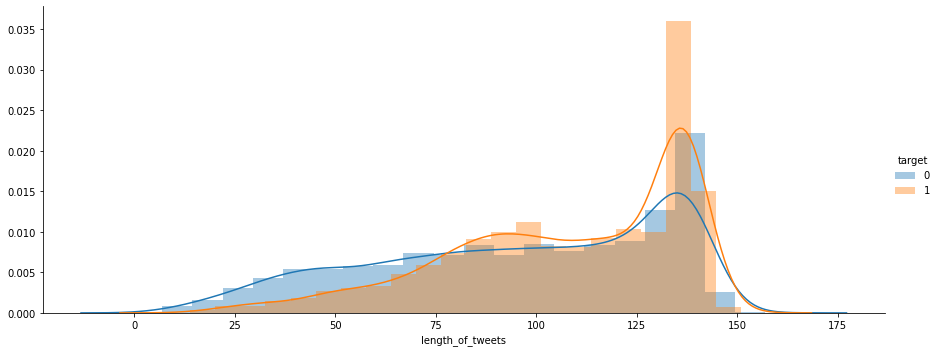

In [ ]:
#length distributions
sns.FacetGrid(df,hue="target", height=5, aspect=2.5).map(sns.distplot, "length_of_tweets").add_legend()

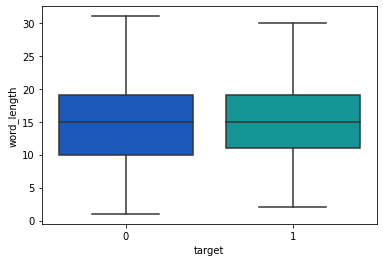

In [ ]:
#box plot
df["word_length"] = df["text"].str.split().apply(len)
sns.boxplot(y="word_length", x= "target", data=df, palette = "winter")

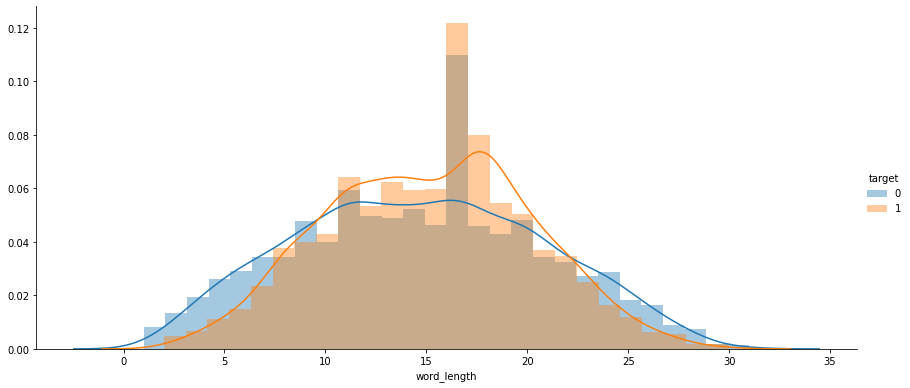

In [ ]:
def dist_plot(input_feature):
    sns.FacetGrid(df, hue="target", size=5.5, aspect=2.2).map(sns.distplot, input_feature).add_legend()
    pt.show()
dist_plot("word_length")

<pre>
There is a overlap of characters and words present in tweets in both target class. Also there are some outliers present in positive target class as we can see in box plot.
</pre>

<h1>3. Text Preprocessing</h1>

Text Preprocessing is an important step for any NLP related project. Here I am using <b>glove.840B.300d</b> pre-trained embedding to create a text corpus.

I will try to keep my text corpus as close to embeddings. This process will help during the sequence prediction of words using LSTM.

<h2>3.1 Loading Glove Embedding</h2|>

In [ ]:
%%time
def GloVe(file_path):
    '''
    parameter : file_path(embedding file)
    return : embedding_matrix(dictionary)
    '''
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    #code to get the dict of embedding_matrix
    embedding_matrix = dict(get_coefs(*w.split(" ")) for w in open(file_path, encoding='latin'))
    return embedding_matrix

embedding_matrix = GloVe("/content/drive/MyDrive/glove.840B.300d.txt")

CPU times: user 2min 32s, sys: 4.84 s, total: 2min 37s
Wall time: 2min 46s


<h2>3.2 Defined contractions and punctuations</h2>

In [ ]:
#Source: - https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#some of the known contractions
contractions = {"'aight": 'alright', "ain't": 'am not', "amn't": 'am not', "aren't": 'are not', "can't": 'can not', "'cause": 'because', "could've": 'could have', "couldn't": 'could not',
                "couldn't've": 'could not have', "daren't": 'dare not', "daresn't": 'dare not', "dasn't": 'dare not', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', 
                'dunno': "don't know", "d'ye": 'do you', "e'er": 'ever', "everybody's": 'everybody is', "everyone's": 'everyone is', 'finna': 'fixing to', "g'day": 'good day', 
                'gimme': 'give me', "giv'n": 'given', 'gonna': 'going to', "gon't": 'go not', 'gotta': 'got to', "hadn't": 'had not', "had've": 'had have', "hasn't": 'has not', 
                "haven't": 'have not', "he'd": 'he had', "he'll": 'he will', "he's": 'he is', "he've": 'he have', "how'd": 'how did', 'howdy': 'how do you do', "how'll": 'how will',
                "how're": 'how are', "how's": 'how is', "I'd": 'I had', "I'd've": 'I would have', "I'll": 'I will', "I'm": 'I am', "I'm'a": 'I am about to', "I'm'o": 'I am going to', 
                'innit': 'is it not', "I've": 'I have', "isn't": 'is not', "it'd ": 'it would', "it'll": 'it will', "it's ": 'it is', 'iunno': "I don't know", "let's": 'let us', 
                "ma'am": 'madam', "mayn't": 'may not', "may've": 'may have', 'methinks': 'me thinks', "mightn't": 'might not', "might've": 'might have', "mustn't": 'must not', 
                "mustn't've": 'must not have', "must've": 'must have', "needn't": 'need not', 'nal': 'and all', "ne'er": 'never', "o'clock": 'of the clock', "o'er": 'over',
                "ol'": 'old', "oughtn't": 'ought not', "'s": 'is', "shalln't": 'shall not', "shan't": 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', 
                "should've": 'should have', "shouldn't": 'should not', "shouldn't've": 'should not have', "somebody's": 'somebody has', "someone's": 'someone has', 
                "something's": 'something has', "so're": 'so are', "that'll": 'that will', "that're": 'that are', "that's": 'that is', "that'd": 'that would', "there'd": 'there would', 
                "there'll": 'there will', "there're": 'there are', "there's": 'there is', "these're": 'these are', "they've": 'they have', "this's": 'this is', "those're": 'those are',
                "those've": 'those have', "'tis": 'it is', "to've": 'to have', "'twas": 'it was', 'wanna': 'want to', "wasn't": 'was not', "we'd": 'we would',  "we'd've": 'we would have',
                "we'll": 'we will', "we're": 'we are', "we've": 'we have', "weren't": 'were not',  "what'd": 'what did', "what'll": 'what will', "what're": 'what are', 
                "what's": 'what does', "what've": 'what have',"when's": 'when is', "where'd": 'where did', "where'll": 'where will', "where're": 'where are',"where's": 'where is',
                "where've": 'where have', "which'd": 'which would', "which'll": 'which will', "which're": 'which are',"which's": 'which is', "which've": 'which have', "who'd": 'who would',
                "who'd've": 'who would have', "who'll": 'who will', "who're": 'who are', "who'ves": 'who is', "who'": 'who have',"why'd": 'why did', "why're": 'why are', "why's": 'why does',
                "willn't": 'will not', "won't": 'will not', 'wonnot': 'will not', "would've": 'would have', "wouldn't": 'would not', "wouldn't've": 'would not have',"y'all": 'you all',
                "y'all'd've": 'you all would have', "y'all'd'n've": 'you all would not have',"y'all're": 'you all are', "cause":"because","have't":"have not","cann't":"can not",
                "ain't":"am not", "you'd": 'you would', "you'll": 'you will', "you're": 'you are', "you've": 'you have', 'cannot': 'can not', 'wont': 'will not', "You'": 'Am not', 
                "Ain'": 'Am not', "Amn'": 'Am not', "Aren'": 'Are not', "Can'": 'Because', "Could'": 'Could have', "Couldn'": 'Could not have', "Daren'": 'Dare not', "Daresn'": 'Dare not',
                "Dasn'": 'Dare not', "Didn'": 'Did not', "Doesn'": 'Does not', "Don'": "Don't know", "D'": 'Do you', "E'": 'Ever', "Everybody'": 'Everybody is', "Everyone'": 'Fixing to', 
                "G'": 'Give me', "Giv'": 'Going to', "Gon'": 'Got to', "Hadn'": 'Had not', "Had'": 'Had have', "Hasn'": 'Has not', "Haven'": 'Have not', "He'": 'He have', "How'": 'How is',
                "I'": 'I have', "Isn'": 'Is not', "It'": "I don't know", "Let'": 'Let us', "Ma'": 'Madam', "Mayn'": 'May not', "May'": 'Me thinks', "Mightn'": 'Might not', 
                "Might'": 'Might have', "Mustn'": 'Must not have', "Must'": 'Must have', "Needn'": 'And all', "Ne'": 'Never', "O'": 'Old', "Oughtn'": 'Is', "Shalln'": 'Shall not',
                "Shan'": 'Shall not', "She'": 'She is', "Should'": 'Should have', "Shouldn'": 'Should not have', "Somebody'": 'Somebody has', "Someone'": 'Someone has', 
                "Something'": 'Something has', "So'": 'So are', "That'": 'That would', "There'": 'There is', "They'": 'They have', "This'": 'This is', "Those'": 'It is', "To'": 'Want to',
                "Wasn'": 'Was not', "Weren'": 'Were not', "What'": 'What have', "When'": 'When is', "Where'": 'Where have', "Which'": 'Which have', "Who'": 'Who have', "Why'": 'Why does',
                "Willn'": 'Will not', "Won'": 'Will not', "Would'": 'Would have',"Wouldn'": 'Would not have', "Y'": 'You all are',"What's":"What is","What're":"What are","what's":"what is",
                "what're":"what are", "Who're":"Who are", "your're":"you are","you're":"you are", "You're":"You are","We're":"We are", "These'": 'These have', "we're":"we are",
                "Why're":"Why are","How're":"How are ","how're ":"how are ","they're ":"they are ", "befo're":"before","'re ":" are ",'don"t ':"do not", "Won't ":"Will not ",
                "could't":"could not", "would't":"would not", "We'": 'We have',"Hasn't":"Has not","n't":"not", 'who"s':"who is"}
#punctuations to be removed
strings = "&${}?/.£@©¡¢(¼¬>+´,^`=[|¨~)]_\-«%!;¤*':÷"
#correct words
correct_words = {"TyphoonDevastated":"Typhoon Devastated", "selfimage":"self image", "Time20150806":"Time 20150806", "ArianaGrande":"Ariana Grande","IranDeal":"Iran Deal","53inch":"53 inch",
                 "RÌunion":"Reunion", "MeatLoving":"Meat Loving", "wheavenly ":"heavenly", "MikeParrActor":"Mike Parr Actor","ChicagoArea":"Chicago Area", "KerrickTrial":"Kerrick Trial",
                 "PantherAttack":"Panther Attack", "YoungHeroesID":"Young Heroes ID", "socialnews":"social news", "CollisionNo":"Collision No", "USAgov":"USA gov", "MTVHottest":"MTV Hottest",
                 "JapÌn":"Japan","360WiseNews":"360 Wise News", "DiamondKesawn":"Diamond Kesawn","TripleDigit":"Triple Digit"}

<h2>3.3 function</h2>

In [ ]:
def preprocessing(text, embedding, contractions, correct_words, strings):
    
    #punctuations table
    translate_table = dict((ord(char), None) for char in strings) 
    sent_tokenizer = nltk.TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)
    
    for idx,tweet in enumerate(text.values):
        
        tweet = re.sub(r'^RT[\s]+', '', tweet) #removes retweets
        tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)
        tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) # removes hypertext
        
        #emoji removal
        emoji= re.compile("["u"\U0001F600-\U0001F64F" #emoticons
                            u"\U0001F300-\U0001F5FF" #symbols&pics
                            u"\U0001F680-\U0001F6FF" #transportation pic
                            u"\U0001F1E0-\U0001F1FF" #flags
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags = re.UNICODE)
        tweet = emoji.sub(r'', tweet)

        #decontraction
        tweet = ' '.join(word.replace(word,contractions[word]) if word in contractions
                    else word for word in tweet.split())
        tweet = re.sub(r"\'s", " ", tweet); tweet = re.sub(r"n\'t", " not ", tweet)
        tweet = re.sub(r"\'re ", " are ", tweet); tweet = re.sub(r"\'d ", " would", tweet)
        tweet = re.sub(r"\'ll ", " will", tweet); tweet = re.sub(r"\'ve ", " have", tweet)
        tweet = re.sub(r"\'m ", " am", tweet)
        
        #general
        tweet = re.sub(r'#', '', tweet); tweet = re.sub(r"Û_","",tweet)
        tweet = re.sub(r"ÛÒ","",tweet); tweet = re.sub(r"ÛÓ","",tweet)
        tweet = re.sub(r"ÛÏ","",tweet); tweet = re.sub(r"Ûª","'",tweet)
        tweet = re.sub(r"åÊ"," ",tweet)
        
        #removal of punctuations
        tweet = tweet.translate(translate_table)
        
        #replace incorrect words
        tweet = ' '.join(word.replace(word,correct_words[word]) if word in correct_words else 
                         word for word in tweet.split())
        
        #tokenizing sentences
        sent = ""
        tokens = sent_tokenizer.tokenize(tweet)
        for word in tokens:
            if word in embedding:
                pass
            else:
                if word.istitle() in embedding:
                    word = word.istitle()
                elif word.islower() in embedding:
                    word = word.lower()
            #adding sentences        
            sent += word + " "
            
        #remove unwanted spaces
        sent = re.sub("\s{2}\s+"," ",sent)
        sent = re.sub("\s{2}"," ",sent)
        #assigning sentences back to the feature
        text.values[idx] = sent.strip()
    
    return text

In [ ]:
%%time
df['preprocessed_text'] = preprocessing(df['text'], embedding_matrix, contractions, correct_words, strings)
test_df['preprocessed_text'] = preprocessing(test_df['text'], embedding_matrix, contractions, correct_words, strings)

CPU times: user 960 ms, sys: 3.02 ms, total: 963 ms
Wall time: 967 ms


<h2>3.4 checking for coverage of words in the embedding matrix</h2>

In [ ]:
#checking coverage for words present in question_text and in embedding_matrix
def coverage(vocab, embeddings_index):
    #Initializing values
    known_words = defaultdict(int)
    unknown_words = defaultdict(int)
    knownWordsVal = 0
    unknownWordsVal = 0
    #iterating words
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            knownWordsVal += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            unknownWordsVal += vocab[word]
            pass
    
    #printing values
    print('Found {:.2%} of words in the embedding of the question text vocab'
           .format(len(known_words) / len(vocab)))
    print('Found {:.2%} of the words in the question text vocab'.format(knownWordsVal / (knownWordsVal + unknownWordsVal)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

#text vocabulary function to check coverage 
def text_vocab(text):
    freq_dict = defaultdict(int)
    total_sent = text.apply(lambda x: x.split()).values
    for sent in total_sent:
        for token in sent:
            freq_dict[token] += 1
    return freq_dict

In [ ]:
%%time
training_vocab = text_vocab(df['preprocessed_text'])
oov_glove = coverage(training_vocab, embedding_matrix)

Found 79.56% of words in the embedding of the question text vocab
Found 95.11% of the words in the question text vocab
CPU times: user 159 ms, sys: 4.94 ms, total: 164 ms
Wall time: 167 ms


<pre>
The pre trained embedding is covering 80% of the unique words present in the text corpus which is a good result.
</pre>

<h2>3.5 word distribution analysis after text preprocessing</h2>

In [ ]:
df["word_length_preprocessed"] = df["preprocessed_text"].str.split().apply(len)
print("Minimum and Maximum length of words in a tweet present in the dataset is {} and {} respectively.".
      format(min(df["word_length"]), max(df["word_length"])))

Minimum and Maximum length of words in a tweet present in the dataset is 1 and 31 respectively.


In [ ]:
#there are lots of outlier present which we can see from box plot let's check the percentile values
for i in range(0, 99, 10):
    print(str(i) + "th percentile : "+ str(np.percentile(list(df["word_length_preprocessed"].values), i)))
for i in range(91, 100):
    print(str(i) + "th percentile : "+ str(np.percentile(list(df["word_length_preprocessed"].values), i)))
for i in range(1,11):
    i = (i/10) + 99
    print(str(i) + "th percentile : "+ str(np.percentile(list(df["word_length_preprocessed"].values), i)))

0th percentile : 1.0
10th percentile : 7.0
20th percentile : 9.0
30th percentile : 11.0
40th percentile : 12.0
50th percentile : 14.0
60th percentile : 16.0
70th percentile : 17.0
80th percentile : 20.0
90th percentile : 23.0
91th percentile : 23.0
92th percentile : 23.0
93th percentile : 24.0
94th percentile : 24.0
95th percentile : 25.0
96th percentile : 25.0
97th percentile : 26.0
98th percentile : 27.0
99th percentile : 28.0
99.1th percentile : 28.0
99.2th percentile : 28.0
99.3th percentile : 29.0
99.4th percentile : 29.0
99.5th percentile : 29.0
99.6th percentile : 29.0
99.7th percentile : 29.493999999999687
99.8th percentile : 30.0
99.9th percentile : 30.498000000000502
100.0th percentile : 32.0


<pre> As the word length is not much extreme after preprocessing, we can go for 30 as MAXLENGTH.

<h2>3.6 Saving File</h2>

In [ ]:
df.to_csv("/content/drive/MyDrive/train_mod.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/test_df.csv", index=False)

<h1>4. Train Test Split</h1>

In [ ]:
from sklearn.model_selection import train_test_split
y = df['target']
X = df.drop(columns = ['target'])

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, stratify=y)
print("The shape of train,cv & test dataset before conversion into vector")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(test_df.shape)

The shape of train,cv & test dataset before conversion into vector
(6002, 5) (6002,)
(1501, 5) (1501,)
(3263, 5)


<h1>5. tokenization and sequence padding of the dataset</h1>

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() #creating object
tokenizer.fit_on_texts(X['preprocessed_text']) #fitting on train data

encoded_docs_train = tokenizer.texts_to_sequences(X_train['preprocessed_text'])
encoded_docs_cv = tokenizer.texts_to_sequences(X_cv['preprocessed_text'])
encoded_docs_test = tokenizer.texts_to_sequences(test_df['preprocessed_text'])

In [ ]:
EMBEDDING_DIM = 300
MAXLENGTH = 30
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
#PADDING OF SEQUENCES
Xtrain = tf.keras.preprocessing.sequence.pad_sequences(encoded_docs_train, maxlen = MAXLENGTH, padding='post')
Xcv = tf.keras.preprocessing.sequence.pad_sequences(encoded_docs_cv, maxlen = MAXLENGTH, padding='post')
Xtest = tf.keras.preprocessing.sequence.pad_sequences(encoded_docs_test, maxlen = MAXLENGTH, padding='post')

<h1>6. creating embedding matrix</h1>

In [ ]:
#getting embedding matrix of 300 dim
words = set(embedding_matrix.keys())
embeddings = np.zeros((VOCAB_SIZE, 300))
for word, idx in tokenizer.word_index.items():
    if word in words:
        embedding_vector = embedding_matrix[word]
        embeddings[idx] = embedding_vector

print('The shape of emdedding matrix is: ',embeddings.shape)

The shape of emdedding matrix is:  (17795, 300)


<h1>7. categorizing output files</h1>

In [ ]:
ytrain = tf.keras.utils.to_categorical(y_train, 2)
ycv = tf.keras.utils.to_categorical(y_cv, 2)

<h1>8.callback</h1>

In [ ]:
#earlystoping helps in stop the trsining when model starts overfitting
earlyStopping = EarlyStopping(monitor='val_loss', #will be based on validation loss
                              min_delta=0, 
                              patience=1, #patience 1 means only a small amount of overfitting is tolerated
                              verbose=0, 
                              mode='auto')

#Custom F1 score callback
class F1_SCORE(tf.keras.callbacks.Callback):

    def __init__(self,train_data, val_data):
        self.X_train, self.y_train = train_data[0], train_data[1]
        self.X_val, self.y_val = val_data[0], val_data[1]

    def on_train_begin(self, logs = {}):
        self.F1 = list()

    def on_epoch_end(self, epoch, logs = {}):
        #F1 Score
        y_pred = np.asarray(self.model.predict(self.X_val)).round()
        F1Score = sklearn.metrics.f1_score(self.y_val, y_pred, average=None)
        self.F1.append(F1Score)

        print(" - F1 SCORE: {}".format(np.round(F1Score,4)))

In [ ]:
F1_Score = F1_SCORE(train_data=(Xtrain, ytrain),
                    val_data=(Xcv, ycv))

<h1>9.Attention with LSTM</h1>

<h2>9.1 Custom Attention Layer</h2>

In [ ]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, att_units, name=None, **kwargs):

        super(Attention, self).__init__(name=name)
        self.att_units = att_units  #number of attention units to be provided
        super(Attention, self).__init__(**kwargs)
        
        # Intialize variables needed for Concat score function here
        self.W1=tf.keras.layers.Dense(att_units)
        self.W2=tf.keras.layers.Dense(att_units)
        self.V=tf.keras.layers.Dense(1)

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"att_units": self.att_units})
        return config  

    def call(self,lstm_output, hidden_state):
        
        """
        hidden state shape == (batch_size, hidden size)
        lstm output shape == (batch_size, max_length, hidden size)
        """
        
        #state_with_time_axis shape == (batch_size, 1, hidden size)
        #we are doing this to broadcast addition along the time axis to calculate the score
        state_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        #score shape == (batch_size, max_length, 1)
        #we get 1 at the last axis because we are applying score to self.V
        #the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(state_with_time_axis) + self.W2(lstm_output)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights=tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights*lstm_output
        context_vector = tf.reduce_sum(context_vector, axis=1)  

        return context_vector, attention_weights

<h2>9.2 Model Pipeline</h2>

In [ ]:
#attention model
def AttetionModel(MAXLENGTH, VOCAB_SIZE, LSTM_UNITS, ATT_UNITS, DENSE_UNITS, EMBEDDING_MATRIX, ):
    
    INPUT = Input(shape=(MAXLENGTH,), dtype='int32', name='Input_Layer')
    EMBEDDING = Embedding(VOCAB_SIZE,
                          EMBEDDING_DIM,
                          weights=[EMBEDDING_MATRIX],
                          input_length=MAXLENGTH,
                          trainable=False,
                          name="Embedding_Layer")(INPUT)
    SPATIAL_DP = tf.keras.layers.SpatialDropout1D(0.2, name="Spatial_Dropout1D")(EMBEDDING)
    LSTM_OUTPUT, FW_HIDDEN_ST, FW_CELL_ST, BW_HIDDEN_ST, BW_CELL_ST = tf.keras.layers.Bidirectional(LSTM(LSTM_UNITS,
                                                                                                         return_sequences=True,
                                                                                                         return_state=True))(SPATIAL_DP)
    HIDDEN_STATE = tf.keras.layers.Concatenate()([FW_HIDDEN_ST, BW_HIDDEN_ST])
    CONTEXT_VECTOR, _ = Attention(ATT_UNITS)(LSTM_OUTPUT, HIDDEN_STATE)
    FLAT = tf.keras.layers.Flatten()(CONTEXT_VECTOR)
    DROPOUT = Dropout(0.2)(FLAT)
    DENSE = Dense(DENSE_UNITS, activation='relu', name= "Dense_Layer")(DROPOUT)
    OUTPUT = Dense(2, activation='sigmoid', name= "Output")(DENSE)

    return Model(INPUT,OUTPUT)

<h2>9.3 Fit and Compile</h2>

In [ ]:
LSTM_UNITS = 64 
ATT_UNITS = 10
DENSE_UNITS = 32
BATCH_SIZE = 128
EPOCH = 10

model = AttetionModel(MAXLENGTH, VOCAB_SIZE, LSTM_UNITS, ATT_UNITS, DENSE_UNITS, embeddings, )
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.fit(Xtrain, 
          ytrain, 
          batch_size=BATCH_SIZE, 
          verbose=1, 
          epochs=EPOCH,
          validation_data=(Xcv,ycv), 
          shuffle=True,
          callbacks=[earlyStopping, F1_Score])

Epoch 1/10
47/47 [==============================] - 2s 45ms/step - loss: 0.5500 - accuracy: 0.7318 - val_loss: 0.4477 - val_accuracy: 0.8095
Epoch 2/10
47/47 [==============================] - 1s 15ms/step - loss: 0.4245 - accuracy: 0.8136 - val_loss: 0.4306 - val_accuracy: 0.8115
Epoch 3/10
47/47 [==============================] - 1s 15ms/step - loss: 0.4082 - accuracy: 0.8216 - val_loss: 0.4342 - val_accuracy: 0.8101


<h2>9.4 Prediction with Best Threshold</h2>

In [ ]:
#prediction
ypred = model.predict(Xcv, batch_size=128,verbose=1)

#getting threshold
threshold = dict()
for thresh in np.arange(0.1, 0.501, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, round(list(sklearn.metrics.f1_score(ycv, (ypred>thresh).astype(int),
                                                                                                average=None))[1],3)))
    threshold[thresh] = round(list(sklearn.metrics.f1_score(ycv, 
                                                            (ypred>thresh).astype(int), 
                                                            average=None))[1],3)
print("\nThe best threshold is:",max(threshold, 
                                     key=threshold.get))

12/12 [==============================] - 0s 6ms/step
F1 score at threshold 0.1 is 0.656
F1 score at threshold 0.15 is 0.71
F1 score at threshold 0.2 is 0.74
F1 score at threshold 0.25 is 0.755
F1 score at threshold 0.3 is 0.764
F1 score at threshold 0.35 is 0.757
F1 score at threshold 0.4 is 0.766
F1 score at threshold 0.45 is 0.765
F1 score at threshold 0.5 is 0.761

The best threshold is: 0.4


In [ ]:
#printing classification report using the best threshold
ypredicted = (ypred>max(threshold, key=threshold.get)).astype(int)
print("Classification Report:\n",sklearn.metrics.classification_report(ycv,ypredicted))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       861
           1       0.79      0.75      0.77       640

   micro avg       0.79      0.85      0.82      1501
   macro avg       0.79      0.83      0.81      1501
weighted avg       0.79      0.85      0.81      1501
 samples avg       0.81      0.85      0.82      1501



In [ ]:
#predicting test data
ypredict = list()
ypred = model.predict(Xtest, batch_size=512,verbose=1)
for i in ypred:
    ypredict.append((i[1]>max(threshold, key=threshold.get)).astype(int))

#creating dataframe
test = pd.DataFrame({"id":test_df["id"].values})
test['target'] = ypredict
print("Test Output:\n",test['target'].value_counts())

#test.to_csv('submission.csv', index=False)

7/7 [==============================] - 0s 10ms/step
Test Output:
 0    1944
1    1319
Name: target, dtype: int64
